# Modelling with the MORPH-II dataset
To Measure the gender bias in the original dataset I first formed an EDA which can be found in eda.ipynb. Next created a model and iterated over the model several times. Finally after being satisfied with the model, I measured the difference in MAE between gender, both for classification and regression
- [1. Load Metadata](#1-load-metadata)
- [2. Choose Base Model](#2-choose-base-model)
- [3. Modify Model](#3-modify-model)
    - [3.1. Modify Last Layer](#31-modify-last-layer)   
    - [3.2. Freeze Layers](#32-freeze-layers)
- [4. Loss and Optimizer](#4-loss-and-optimizer)
- [5. Setup Training](#5-setup-training)
- [6. Training](#6-training)
- [7. Results](#7-results)
- [8. Conclusion](#8-conclusion)
- [9. Second Iteration](#9-second-iteration)
- [10. Third Iteration](#10-third-iteration)
- [11. Fourth Iteration](#11-fourth-iteration)
- [12. Test on the testset per gender](#12-test-on-the-testset-per-gender)
- [13. Measuring Bias](#13-measuring-bias)



### 1. Load Metadata

In [2]:
import pandas as pd
from PIL import Image

# Load splits
train_df = pd.read_csv("dataset/index/train.csv")
val_df   = pd.read_csv("dataset/index/validation.csv")
test_df  = pd.read_csv("dataset/index/test.csv")

# Add paths
train_df['filepath'] = "dataset/images/train/" + train_df['filename']
val_df['filepath']   = "dataset/images/validation/" + val_df['filename']
test_df['filepath']  = "dataset/images/test/" + test_df['filename']

# show data
train_df


,age,gender,filename,filepath
0,3,1,00013_00M19.JPG,dataset/images/train/00013_00M19.JPG
1,3,1,00013_01M19.JPG,dataset/images/train/00013_01M19.JPG
2,3,1,00013_02M19.JPG,dataset/images/train/00013_02M19.JPG
3,3,1,00022_03M19.JPG,dataset/images/train/00022_03M19.JPG
4,4,1,00022_04M20.JPG,dataset/images/train/00022_04M20.JPG
...,...,...,...,...
40007,11,0,99984_02F27.JPG,dataset/images/train/99984_02F27.JPG
40008,12,1,99990_01M28.JPG,dataset/images/train/99990_01M28.JPG
40009,12,1,99990_02M28.JPG,dataset/images/train/99990_02M28.JPG
40010,23,1,99999_02M39.JPG,dataset/images/train/99999_02M39.JPG


### 2. Choose base model
To start with the best base model as possible, I decided to choose the VGG16 model trained on ImageNet. As loss metric I CrossEntropyLoss since that is the most commonly used metric for classification tasks, and I am planning to solve this task using classification. All these decisions are based on the DEX paper.

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms  

# download model to notebook
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

In [4]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 3. Modify model
#### 3.1 Modify last layer
Currently the model is built for classifying 1000 classes. The issue lies in the last layer, layer 6. This layer transforms the 4096 neurons to 1000 neurons (which can then be translated to one of the 1000 ImageNet classes). But that is way too much classes for my case. The lowest age in my dataset is 16 and the highest age is 77. This means that I need a total of 62 classes.

In [5]:
import torch.nn as nn


model.classifier[6] = nn.Linear(in_features=4096, out_features=62) # 62 because i have 62 different ages in my set


In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### 3.2 Freeze Layers
I Don't want to retrain the base model since it is already very good. I just want to train the classifier layers. since that part has a different task now.

In [7]:
# freeze feature layers
for param in model.features.parameters():
    param.requires_grad = False


In [8]:
# print layers
for name, param in model.named_parameters():
    print(name, param.requires_grad)


features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight False
features.17.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.26.weight False
features.26.bias False
features.28.weight False
features.28.bias False
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


### 4. Loss and Optimizer

In [9]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)


### 5. Setup Training

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

# VGG16 expects 224x224 images and normalized values
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class MorphDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filepath']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(row['age'], dtype=torch.long)
        return image, label
    

    # Example custom Dataset
class MorphWithGenderDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filepath']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        age = row['age']
        gender = row['gender']
        return image, age, gender



In [16]:
from torch.utils.data import DataLoader

train_dataset = MorphDataset(train_df, transform=transform)
val_dataset   = MorphDataset(val_df, transform=transform)
test_dataset  = MorphDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

train_dataset_gender = MorphWithGenderDataset(train_df, transform=transform)
val_dataset_gender   = MorphWithGenderDataset(val_df, transform=transform)
test_dataset_gender  = MorphWithGenderDataset(test_df, transform=transform)

train_loader_gender = DataLoader(train_dataset_gender, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader_gender   = DataLoader(val_dataset_gender, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)
test_loader_gender  = DataLoader(test_dataset_gender, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)


### 6. Training
Training isn't done in the notebook, but this is the code used for training. All the training is done in a .py file since that allowed me for faster training. `modelling.py` is nothing more than all the code leading up to this point refactored in a single file

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


CUDA available: True
Device name: NVIDIA GeForce RTX 2060


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# --- DEVICE SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to GPU/CPU
model = model.to(device)

# --- LOSS & OPTIMIZER ---
criterion = nn.CrossEntropyLoss()  # suitable for multi-class classification
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# --- TRAINING LOOP ---
num_epochs = 1  # adjust as needed

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    model.train()  # enable dropout, batchnorm, etc.
    running_loss = 0.0
    correct = 0
    total = 0

    # --- TRAINING ---
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()             # reset gradients
        outputs = model(images)           # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward()                   # backprop
        optimizer.step()                  # update weights

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total

    # --- LOGGING ---
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

print("\nTraining complete ✅")


Using device: cuda

Epoch [1/1]


  0%|          | 0/1251 [00:00<?, ?it/s]

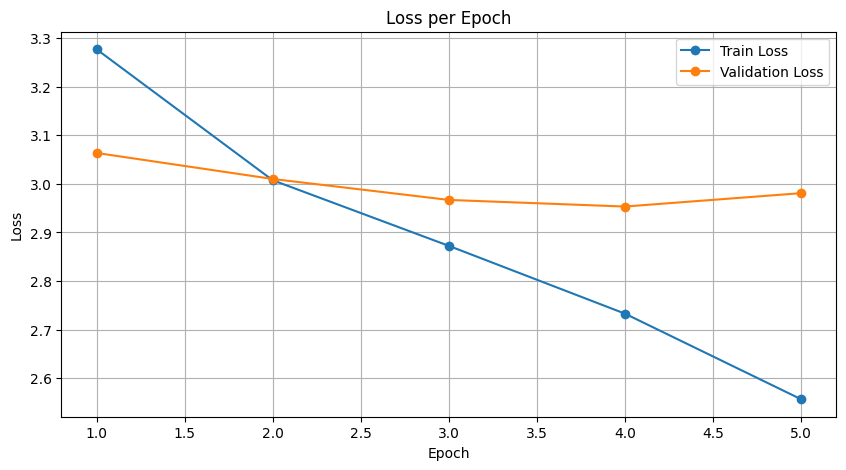

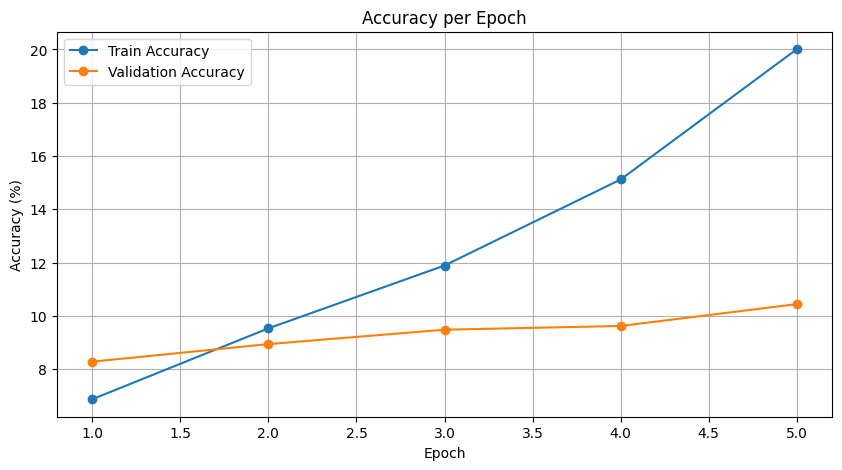

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Load log ---
log_file = "training_log.txt"
df = pd.read_csv(log_file)

# --- Plot Loss ---
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot Accuracy ---
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', marker='o')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()


It's hard to draw any conclusing from only 5 epochs so I won't

### 7. Results
I trained for 5 epochs on the train set. We can load in the model and test it on the val set.

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Dataset class ---
class MorphDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filepath']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['age'], dtype=torch.long)
        return image, label

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Load CSVs ---
val_df = pd.read_csv("dataset/index/validation.csv")
val_df['filepath'] = "dataset/images/validation/" + val_df['filename']

val_dataset = MorphDataset(val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# --- Load model ---
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(4096, 62)
for param in model.features.parameters():
    param.requires_grad = False

# Load saved weights from epoch 5
checkpoint_path = "vgg16_morph2_epoch5.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()

# --- Evaluation ---
criterion = nn.CrossEntropyLoss()
val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

val_loss /= val_total
val_acc = 100 * val_correct / val_total

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")


Using device: cuda


100%|██████████| 157/157 [00:31<00:00,  5.00it/s]

Validation Loss: 2.9808, Validation Accuracy: 10.44%


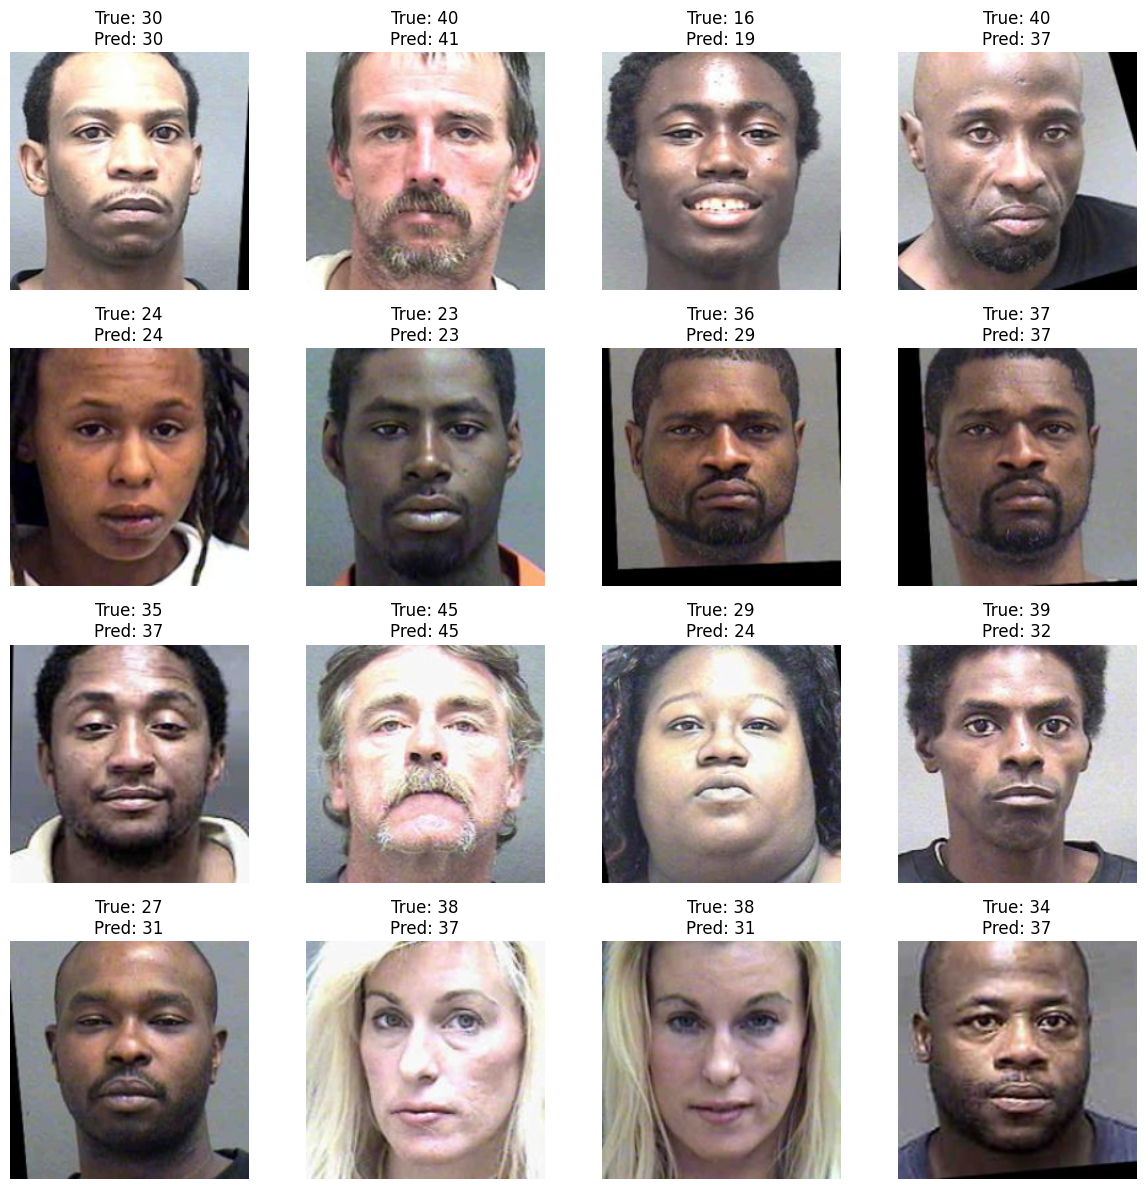

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np

age_offset = 16

# --- Set number of images to visualize ---
num_images = 16
images_shown = 0

# Make a grid
plt.figure(figsize=(12, 12))

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Move to CPU and numpy for plotting
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            img = images[i].permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
            img = np.clip((img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]), 0, 1)  # unnormalize

            true_age = labels[i].item()
            pred_age = predicted[i].item()

            plt.subplot(4, 4, images_shown+1)
            plt.imshow(img)
            plt.title(f"True: {true_age + age_offset}\nPred: {pred_age + age_offset}")
            plt.axis('off')

            images_shown += 1

        if images_shown >= num_images:
            break

plt.tight_layout()
plt.show()


### 8. Conclusion
The model performs suprisingly well for only 5 epochs. But this can be caused by the fact that there are multiple images per person, meaning that there could be indirect cases of data-leakage. Anyway, for now I will train for a serious amount of epochs to see if I can make the model overfit, so I can be just below that.

### 9. Second Iteration
I used the latest model (vgg16_morph2_epoch5) of the first iteration, and trained for another 5 epochs. That gave me the following model: `vgg16_morph2_epoch10`. Below the results including 16 images where I show the prediction of my plain classification prediction and the regression prediction calculated the same way as in the DEX paper.

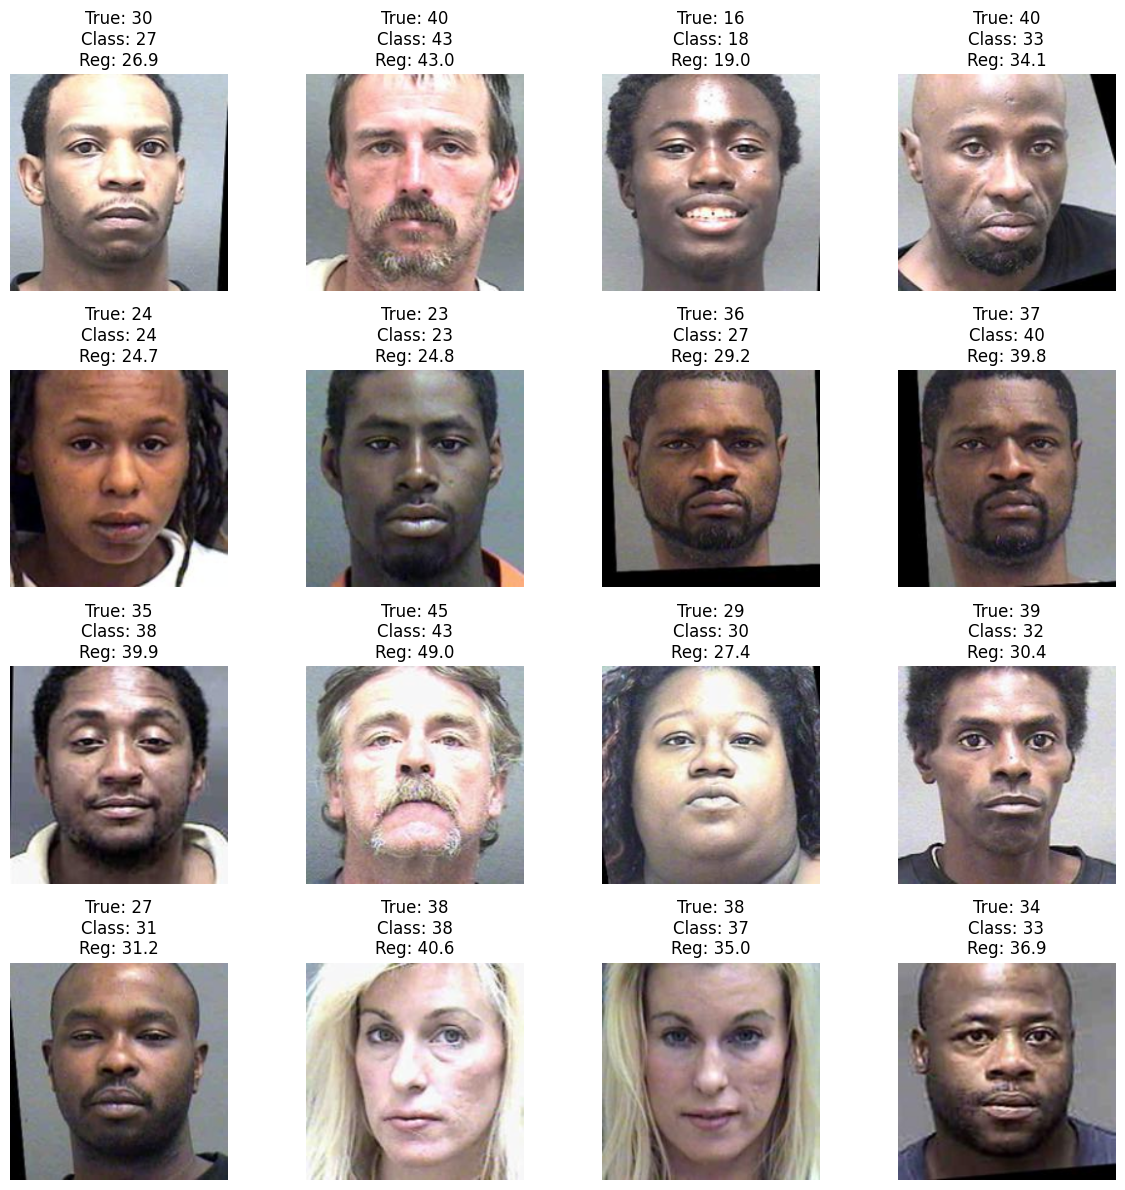

In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn.functional as F

age_offset = 16  # if classes start at 16
num_images = 16
images_shown = 0

plt.figure(figsize=(12, 12))

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # shape: [batch_size, 62]

        # --- Classification prediction ---
        _, class_pred = torch.max(outputs, 1)

        # --- Regression prediction (softmax expected value) ---
        probs = F.softmax(outputs, dim=1)
        ages = torch.arange(62, dtype=torch.float32, device=device)
        reg_pred = torch.sum(probs * ages, dim=1)

        # Move to CPU for plotting
        images = images.cpu()
        labels = labels.cpu()
        class_pred = class_pred.cpu()
        reg_pred = reg_pred.cpu()

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            img = images[i].permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
            img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)  # unnormalize

            true_age = labels[i].item() + age_offset
            cls_age = class_pred[i].item() + age_offset
            reg_age = reg_pred[i].item() + age_offset

            plt.subplot(4, 4, images_shown+1)
            plt.imshow(img)
            plt.title(f"True: {true_age}\nClass: {cls_age}\nReg: {reg_age:.1f}")
            plt.axis('off')

            images_shown += 1

        if images_shown >= num_images:
            break

plt.tight_layout()
plt.show()


The 16 samples create the illusion that classification performs better than regression. But if we look at the complete validation set, It appears that regression has a lower MAE score than classification. Therefore I will keep using classification for training and regression as prediction.

In [12]:
import torch
import torch.nn.functional as F

age_offset = 16
model.eval()

total_samples = 0
cls_mae_sum = 0.0
reg_mae_sum = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Classification prediction
        _, class_pred = torch.max(outputs, 1)

        # Regression prediction (softmax expected value)
        probs = F.softmax(outputs, dim=1)
        ages = torch.arange(62, dtype=torch.float32, device=device)
        reg_pred = torch.sum(probs * ages, dim=1)

        # Add age offset
        true_age = labels.float() + age_offset
        class_age = class_pred.float() + age_offset
        reg_age = reg_pred + age_offset

        # Compute MAE for this batch
        cls_mae_sum += torch.sum(torch.abs(class_age - true_age)).item()
        reg_mae_sum += torch.sum(torch.abs(reg_age - true_age)).item()
        total_samples += labels.size(0)

# Compute average MAE
cls_mae = cls_mae_sum / total_samples
reg_mae = reg_mae_sum / total_samples

print(f"Classification MAE: {cls_mae:.3f}")
print(f"Regression MAE:     {reg_mae:.3f}")


Classification MAE: 4.311
Regression MAE:     3.993


### 10. Third Iteration
Training for 10 epochs didn't show any big progression. Maybe the learning rate was too low? Therefore I will try to now train for more epochs but with a higher learning rate (0.001 instead of 0.0001)

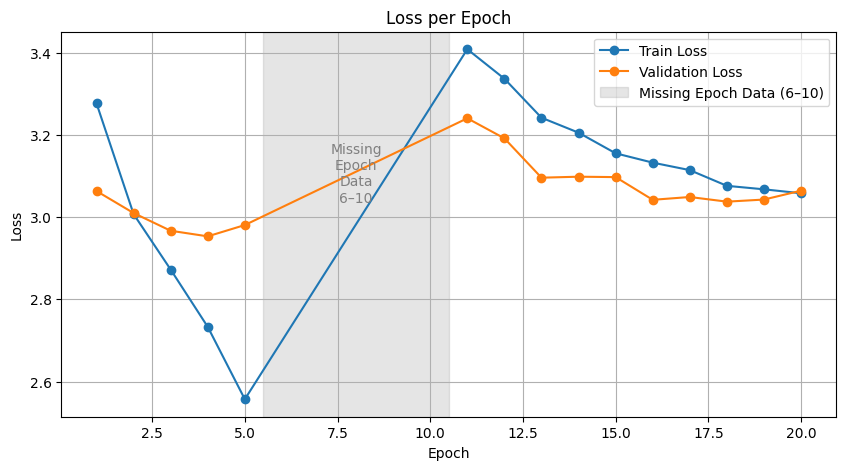

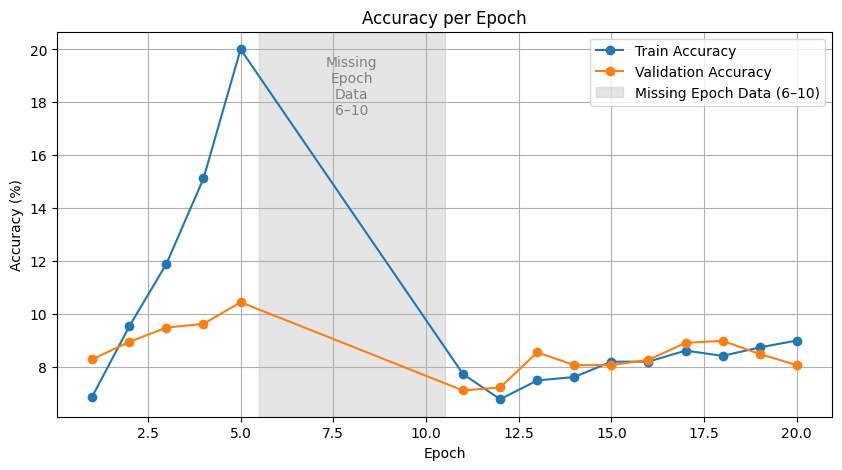

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Load both logs ---
log_file_1 = "./first_iteration/training_log.txt"   # epochs 1–5
log_file_2 = "./third_iteration/training_log.txt"   # epochs 11–20

df1 = pd.read_csv(log_file_1)
df2 = pd.read_csv(log_file_2)

# --- Adjust the second file's epoch numbers ---
# Automatically continue from the last epoch in df1
epoch_offset = df1['epoch'].max()
df2['epoch'] = df2['epoch'] + epoch_offset + 5  # adjust if your df2 starts at 0 or 1

# --- Combine both ---
df = pd.concat([df1, df2], ignore_index=True)

# --- Define the gap region (epochs 6–10) ---
gap_start, gap_end = df1['epoch'].max() + 0.5, df1['epoch'].max() + 5.5

# --- Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')

# Highlight the missing epoch gap
plt.axvspan(gap_start, gap_end, color='gray', alpha=0.2, label='Missing Epoch Data (6–10)')
plt.text((gap_start + gap_end)/2, plt.ylim()[1]*0.9, 'Missing\nEpoch\nData\n6–10',
         ha='center', va='center', fontsize=10, color='gray')

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', marker='o')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')

# Highlight the missing epoch gap
plt.axvspan(gap_start, gap_end, color='gray', alpha=0.2, label='Missing Epoch Data (6–10)')
plt.text((gap_start + gap_end)/2, plt.ylim()[1]*0.9, 'Missing\nEpoch\nData\n6–10',
         ha='center', va='center', fontsize=10, color='gray')

plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()


Interestingly it seems that raising the learning rate made the model worse, indicating that this learning rate most likely cannot learn the complex patterns. For now, I will put back the learning rate at 0.0001 and train for 20 epochs.

### 11. Fourth Iteration
Interestingly the loss becomes higher than the start, most likely meaning it has overfit. After epoch 6, the val set starts increasing in loss.

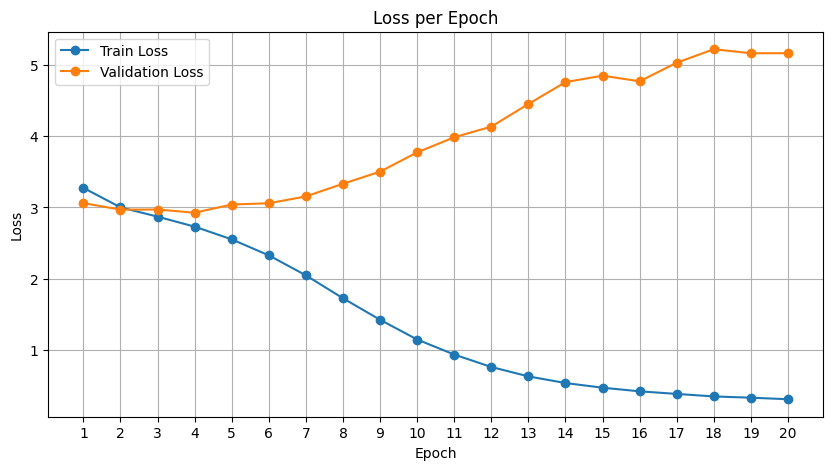

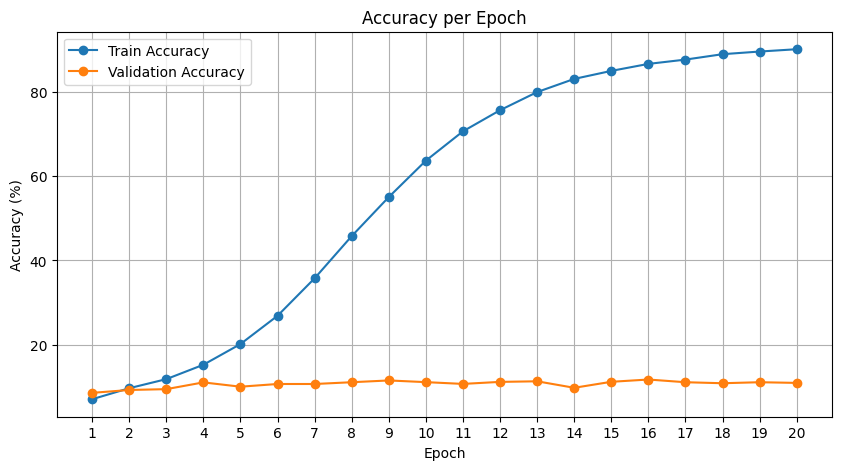

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the log
log_file = "./fourth_iteration/training_log.txt"
df = pd.read_csv(log_file)

# Make sure epochs are integers
df['epoch'] = df['epoch'].astype(int)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(df['epoch'].min(), df['epoch'].max() + 1))
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', marker='o')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(df['epoch'].min(), df['epoch'].max() + 1))
plt.grid(True)
plt.legend()
plt.show()


I can still try all the models on the val set but making them predict a single number.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# ----------------- Settings -----------------
age_offset = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = Path("./fourth_iteration")
output_csv = "mae_results.csv"

# ----------------- Prepare results storage -----------------
results = []

# ----------------- Loop over all models -----------------
for epoch in range(1, 21):
    model_file = model_dir / f"vgg16_morph2_epoch{epoch}.pth"
    print(f"\nProcessing {model_file.name} ...")
    
    # Instantiate fresh VGG16 model
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    model.classifier[6] = nn.Linear(4096, 62)  # 62 output classes
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Load saved weights
    model.load_state_dict(torch.load(model_file, map_location=device))
    model.to(device)
    model.eval()
    
    # Initialize MAE accumulators
    total_samples = 0
    cls_mae_sum = 0.0
    reg_mae_sum = 0.0
    
    # ----------------- Evaluation -----------------
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Evaluating Epoch {epoch}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Classification prediction
            _, class_pred = torch.max(outputs, 1)

            # Regression prediction (softmax expected value)
            probs = F.softmax(outputs, dim=1)
            ages = torch.arange(62, dtype=torch.float32, device=device)
            reg_pred = torch.sum(probs * ages, dim=1)

            # Add age offset
            true_age = labels.float() + age_offset
            class_age = class_pred.float() + age_offset
            reg_age = reg_pred + age_offset

            # Compute MAE for this batch
            cls_mae_sum += torch.sum(torch.abs(class_age - true_age)).item()
            reg_mae_sum += torch.sum(torch.abs(reg_age - true_age)).item()
            total_samples += labels.size(0)

    # Compute average MAE
    cls_mae = cls_mae_sum / total_samples
    reg_mae = reg_mae_sum / total_samples
    
    print(f"Epoch {epoch} -> Classification MAE: {cls_mae:.3f}, Regression MAE: {reg_mae:.3f}")

    # Save results
    results.append({
        "epoch": epoch,
        "classification_mae": cls_mae,
        "regression_mae": reg_mae
    })

# ----------------- Save results to CSV -----------------
df_results = pd.DataFrame(results)
df_results.to_csv(output_csv, index=False)
print(f"\nAll results saved to {output_csv}")




Processing vgg16_morph2_epoch1.pth ...


Evaluating Epoch 1: 100%|██████████| 1251/1251 [00:44<00:00, 27.81it/s]


Epoch 1 -> Classification MAE: 4.674, Regression MAE: 4.283

Processing vgg16_morph2_epoch2.pth ...


Evaluating Epoch 2: 100%|██████████| 1251/1251 [00:45<00:00, 27.75it/s]


Epoch 2 -> Classification MAE: 4.229, Regression MAE: 4.062

Processing vgg16_morph2_epoch3.pth ...


Evaluating Epoch 3: 100%|██████████| 1251/1251 [00:45<00:00, 27.60it/s]


Epoch 3 -> Classification MAE: 4.225, Regression MAE: 3.963

Processing vgg16_morph2_epoch4.pth ...


Evaluating Epoch 4: 100%|██████████| 1251/1251 [00:47<00:00, 26.53it/s]


Epoch 4 -> Classification MAE: 4.118, Regression MAE: 3.862

Processing vgg16_morph2_epoch5.pth ...


Evaluating Epoch 5: 100%|██████████| 1251/1251 [00:48<00:00, 25.94it/s]


Epoch 5 -> Classification MAE: 4.331, Regression MAE: 4.192

Processing vgg16_morph2_epoch6.pth ...


Evaluating Epoch 6: 100%|██████████| 1251/1251 [00:54<00:00, 23.04it/s]


Epoch 6 -> Classification MAE: 4.168, Regression MAE: 3.988

Processing vgg16_morph2_epoch7.pth ...


Evaluating Epoch 7: 100%|██████████| 1251/1251 [00:53<00:00, 23.56it/s]


Epoch 7 -> Classification MAE: 4.195, Regression MAE: 3.872

Processing vgg16_morph2_epoch8.pth ...


Evaluating Epoch 8: 100%|██████████| 1251/1251 [00:52<00:00, 23.97it/s]


Epoch 8 -> Classification MAE: 4.230, Regression MAE: 3.909

Processing vgg16_morph2_epoch9.pth ...


Evaluating Epoch 9: 100%|██████████| 1251/1251 [00:54<00:00, 23.14it/s]


Epoch 9 -> Classification MAE: 4.263, Regression MAE: 3.930

Processing vgg16_morph2_epoch10.pth ...


Evaluating Epoch 10: 100%|██████████| 1251/1251 [00:50<00:00, 25.02it/s]


Epoch 10 -> Classification MAE: 4.309, Regression MAE: 3.999

Processing vgg16_morph2_epoch11.pth ...


Evaluating Epoch 11: 100%|██████████| 1251/1251 [00:49<00:00, 25.21it/s]


Epoch 11 -> Classification MAE: 4.252, Regression MAE: 3.940

Processing vgg16_morph2_epoch12.pth ...


Evaluating Epoch 12: 100%|██████████| 1251/1251 [00:51<00:00, 24.16it/s]


Epoch 12 -> Classification MAE: 4.287, Regression MAE: 3.970

Processing vgg16_morph2_epoch13.pth ...


Evaluating Epoch 13: 100%|██████████| 1251/1251 [00:49<00:00, 25.30it/s]


Epoch 13 -> Classification MAE: 4.442, Regression MAE: 4.056

Processing vgg16_morph2_epoch14.pth ...


Evaluating Epoch 14: 100%|██████████| 1251/1251 [00:50<00:00, 24.60it/s]


Epoch 14 -> Classification MAE: 4.487, Regression MAE: 4.135

Processing vgg16_morph2_epoch15.pth ...


Evaluating Epoch 15: 100%|██████████| 1251/1251 [00:49<00:00, 25.36it/s]


Epoch 15 -> Classification MAE: 4.409, Regression MAE: 4.034

Processing vgg16_morph2_epoch16.pth ...


Evaluating Epoch 16: 100%|██████████| 1251/1251 [00:51<00:00, 24.16it/s]


Epoch 16 -> Classification MAE: 4.406, Regression MAE: 4.054

Processing vgg16_morph2_epoch17.pth ...


Evaluating Epoch 17: 100%|██████████| 1251/1251 [00:47<00:00, 26.17it/s]


Epoch 17 -> Classification MAE: 4.442, Regression MAE: 4.093

Processing vgg16_morph2_epoch18.pth ...


Evaluating Epoch 18: 100%|██████████| 1251/1251 [00:48<00:00, 25.90it/s]


Epoch 18 -> Classification MAE: 4.531, Regression MAE: 4.187

Processing vgg16_morph2_epoch19.pth ...


Evaluating Epoch 19: 100%|██████████| 1251/1251 [00:48<00:00, 25.72it/s]


Epoch 19 -> Classification MAE: 4.541, Regression MAE: 4.225

Processing vgg16_morph2_epoch20.pth ...


Evaluating Epoch 20: 100%|██████████| 1251/1251 [00:50<00:00, 24.93it/s]


Epoch 20 -> Classification MAE: 4.482, Regression MAE: 4.131

All results saved to mae_results.csv


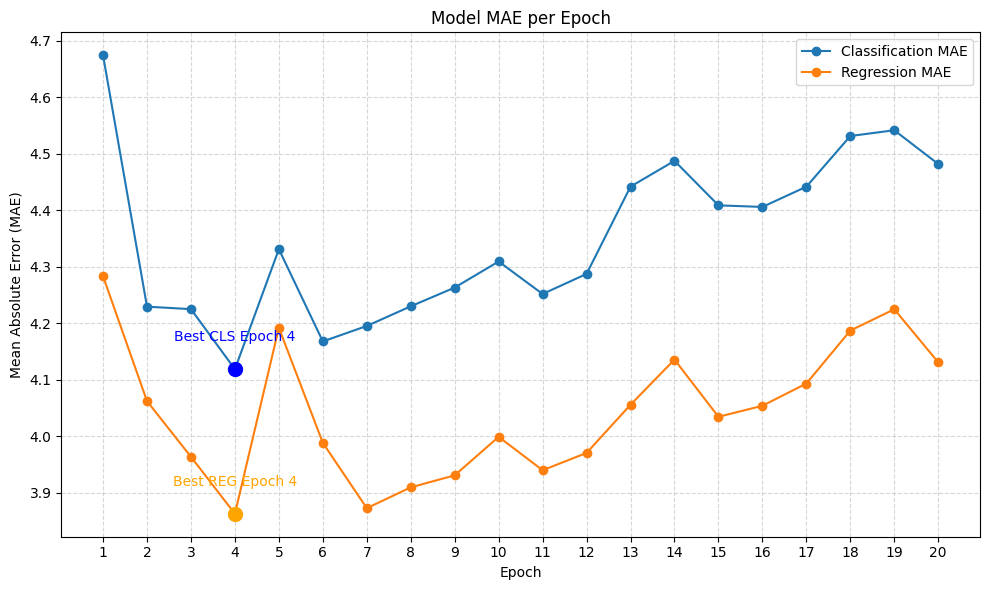

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load data ---
data = pd.read_csv("mae_results.csv")  # replace with your file path

# --- Plot MAE over epochs ---
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['classification_mae'], marker='o', label='Classification MAE')
plt.plot(data['epoch'], data['regression_mae'], marker='o', label='Regression MAE')

# Highlight best epoch
best_cls_epoch = data['classification_mae'].idxmin() + 1
best_reg_epoch = data['regression_mae'].idxmin() + 1
plt.scatter(best_cls_epoch, data.loc[best_cls_epoch-1, 'classification_mae'], color='blue', s=100, zorder=5)
plt.scatter(best_reg_epoch, data.loc[best_reg_epoch-1, 'regression_mae'], color='orange', s=100, zorder=5)
plt.text(best_cls_epoch, data.loc[best_cls_epoch-1, 'classification_mae'] + 0.05,
         f'Best CLS Epoch {best_cls_epoch}', color='blue', ha='center')
plt.text(best_reg_epoch, data.loc[best_reg_epoch-1, 'regression_mae'] + 0.05,
         f'Best REG Epoch {best_reg_epoch}', color='orange', ha='center')

plt.title('Model MAE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(data['epoch'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### 12. Test on the testset per gender
Now that there is a decent model, I am planning to test it on the test set separately for male and female.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# ----------------- Settings -----------------
age_offset = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_file = Path("./fourth_iteration/vgg16_morph2_epoch4.pth")
output_csv = "mae_epoch4_gender_results_testset.csv"

# ----------------- Instantiate VGG16 model -----------------
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(4096, 62)  # 62 output classes
for param in model.features.parameters():
    param.requires_grad = False

# Load saved weights
model.load_state_dict(torch.load(model_file, map_location=device))
model.to(device)
model.eval()

# ----------------- Gender-specific accumulators -----------------
gender_map = {1: 'male', 0: 'female'}
mae_data = {
    'male': {'cls_sum': 0.0, 'reg_sum': 0.0, 'count': 0},
    'female': {'cls_sum': 0.0, 'reg_sum': 0.0, 'count': 0}
}

# ----------------- Evaluation -----------------
with torch.no_grad():
    # Use val_loader_gender which yields (images, labels, gender)
    for batch in tqdm(test_loader_gender, desc=f"Evaluating {model_file.name}"):
        images, labels, gender_batch = batch
        images, labels, gender_batch = images.to(device), labels.to(device), gender_batch.to(device)

        outputs = model(images)

        # Classification prediction
        _, class_pred = torch.max(outputs, 1)

        # Regression prediction (softmax expected value)
        probs = F.softmax(outputs, dim=1)
        ages = torch.arange(62, dtype=torch.float32, device=device)
        reg_pred = torch.sum(probs * ages, dim=1)

        # Add age offset
        true_age = labels.float() + age_offset
        class_age = class_pred.float() + age_offset
        reg_age = reg_pred + age_offset

        # Compute MAE per gender
        for g_id, g_name in gender_map.items():
            mask = (gender_batch == g_id)
            if mask.sum() == 0:
                continue
            mae_data[g_name]['cls_sum'] += torch.sum(torch.abs(class_age[mask] - true_age[mask])).item()
            mae_data[g_name]['reg_sum'] += torch.sum(torch.abs(reg_age[mask] - true_age[mask])).item()
            mae_data[g_name]['count'] += mask.sum().item()

# ----------------- Compute averages -----------------
results = []
for g_name in gender_map.values():
    cls_mae = mae_data[g_name]['cls_sum'] / mae_data[g_name]['count'] if mae_data[g_name]['count'] > 0 else None
    reg_mae = mae_data[g_name]['reg_sum'] / mae_data[g_name]['count'] if mae_data[g_name]['count'] > 0 else None
    print(f"{g_name.capitalize()} samples -> Classification MAE: {cls_mae:.3f}, Regression MAE: {reg_mae:.3f}")
    results.append({
        'gender': g_name,
        'classification_mae': cls_mae,
        'regression_mae': reg_mae
    })

# ----------------- Save results to CSV -----------------
df_results = pd.DataFrame(results)
df_results.to_csv(output_csv, index=False)
print(f"\nGender-specific results saved to {output_csv}")


Evaluating vgg16_morph2_epoch4.pth: 100%|██████████| 1251/1251 [00:45<00:00, 27.63it/s]

Male samples -> Classification MAE: 3.858, Regression MAE: 3.689
Female samples -> Classification MAE: 5.345, Regression MAE: 4.977

Gender-specific results saved to mae_epoch4_gender_results_testset.csv


### 13. Measuring Bias
Both for classification and regression there is a significant difference in MAE between men and women. Since the results in regression are concistently better throughout the experiment, I will only focus on regression prediction results. The difference in MAE on the original dataset is `abs(MAE(Male) - MAE(Female)) = abs(4.98 - 3.69) = 1.29`. Now the goal is to reduce this gender bias using sampling mitigations.

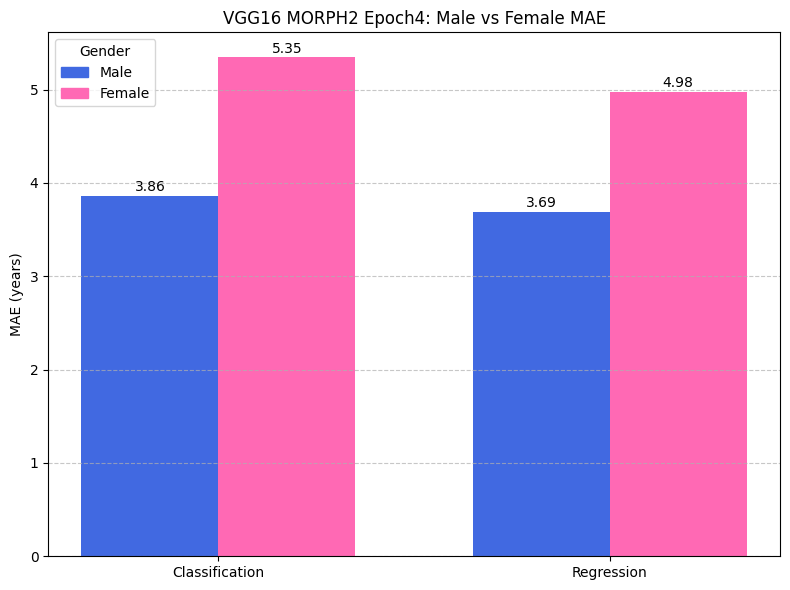

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("mae_epoch4_gender_results_testset.csv")

# Colors
gender_colors = {'male': 'royalblue', 'female': 'hotpink'}

# Positions
x = [0, 1]  # 0 = Classification, 1 = Regression
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

# Classification bars
ax.bar(x[0] - width/2, df.loc[df['gender']=='male', 'classification_mae'].values[0],
       width, color=gender_colors['male'])
ax.bar(x[0] + width/2, df.loc[df['gender']=='female', 'classification_mae'].values[0],
       width, color=gender_colors['female'])

# Regression bars
ax.bar(x[1] - width/2, df.loc[df['gender']=='male', 'regression_mae'].values[0],
       width, color=gender_colors['male'])
ax.bar(x[1] + width/2, df.loc[df['gender']=='female', 'regression_mae'].values[0],
       width, color=gender_colors['female'])

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(['Classification', 'Regression'])
ax.set_ylabel("MAE (years)")
ax.set_title("VGG16 MORPH2 Epoch4: Male vs Female MAE")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Legend (gender only)
ax.legend([plt.Rectangle((0,0),1,1,color=gender_colors['male']),
           plt.Rectangle((0,0),1,1,color=gender_colors['female'])],
          ['Male', 'Female'], title="Gender")

# Annotate values
ax.text(x[0] - width/2, df.loc[df['gender']=='male', 'classification_mae'].values[0]+0.05,
        f"{df.loc[df['gender']=='male', 'classification_mae'].values[0]:.2f}", ha='center')
ax.text(x[0] + width/2, df.loc[df['gender']=='female', 'classification_mae'].values[0]+0.05,
        f"{df.loc[df['gender']=='female', 'classification_mae'].values[0]:.2f}", ha='center')
ax.text(x[1] - width/2, df.loc[df['gender']=='male', 'regression_mae'].values[0]+0.05,
        f"{df.loc[df['gender']=='male', 'regression_mae'].values[0]:.2f}", ha='center')
ax.text(x[1] + width/2, df.loc[df['gender']=='female', 'regression_mae'].values[0]+0.05,
        f"{df.loc[df['gender']=='female', 'regression_mae'].values[0]:.2f}", ha='center')

plt.tight_layout()
plt.show()


### 14. References
Not all the modelling has been performed in this notebook. I also made several python files for faster modelling. these can be found in the associated folders.
- EDA: `./eda.ipynb`
- First Iteration: `./first_iteration/modelling_first_iteration.py`
- Second Iteration: `./second_iteration/modelling_second_iteration.py`
- Third Iteration: `./third_iteration/modelling_third_iteration.py`
- Fourth Iteration: `./fourth_iteration/modelling_fourth_iteration.py`